Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Few-shot Adaptation with Model Agnostic Meta-Learning (MAML)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jaxopt/blob/main/docs/notebooks/implicit_diff/maml.ipynb)


This notebook shows how to use Model Agnostic Meta-Learning (MAML) for few-shot adaptation on a simple regression task. This example appears in section 5.1 of [(Finn et al. 2017)](https://arxiv.org/pdf/1703.03400.pdf). The problem is however solved using *implicit* MAML formulation of [(Rajeswaran et al., 2019)](https://arxiv.org/pdf/1909.04630.pdf).

In [ ]:
%%capture
%pip install jaxopt flax

In [1]:
from typing import Any, Sequence

# activate TPUs if available
try:
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
except KeyError:
    print("TPU not found, continuing without it.")

from jax.config import config
config.update("jax_enable_x64", True)

import jax
from jax import numpy as jnp
from jax import random

from jaxopt import LBFGS
from jaxopt import OptaxSolver
from jaxopt import tree_util

import optax

# we use flax to construct a small multi-layer perceptron
from flax import linen as nn

# for plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
# default values 
n_tasks = 4
MIN_X = -5
MAX_X = 5

# amount of L2 regularization. Higher regularization values will promote
# task parameters that are closer to each other.
L2REG = 1e-2

# for bigger plots
plt.rcParams.update({"figure.figsize": (12, 6)})
plt.rcParams.update({'font.size': 22})

# Problem setup

We consider a multi-task problem, where each task involves regressing from the input to the output of a sine wave. The different tasks have different amplitude and phase of the sinusoid.

In [3]:
def generate_task(key, n_samples_train=6, n_samples_test=6, min_phase=0.5, max_phase=jnp.pi, min_amplitude=0.1, max_amplitude=0.5):
    """Generate a toy 1-D regression dataset."""
    amplitude = random.uniform(key) * (max_amplitude - min_amplitude) + min_amplitude
    
    key, _ = random.split(key)
    phase = random.uniform(key) * (max_phase - min_phase) + min_phase

    key, _ = random.split(key)
    x_train = random.uniform(key, shape=(n_samples_train,)) * (MAX_X - MIN_X) + MIN_X
    x_train = x_train.reshape((-1, 1))  # Reshape to feed into MLP later
    y_train = jnp.sin(phase * x_train) * amplitude

    key, _ = random.split(key)
    x_test = random.uniform(key, shape=(n_samples_test,)) * (MAX_X - MIN_X) + MIN_X
    x_test = x_test.reshape((-1, 1))  # Reshape to feed into MLP later
    y_test = jnp.sin(phase * x_test) * amplitude

    return (x_train, y_train), (x_test, y_test), phase, amplitude

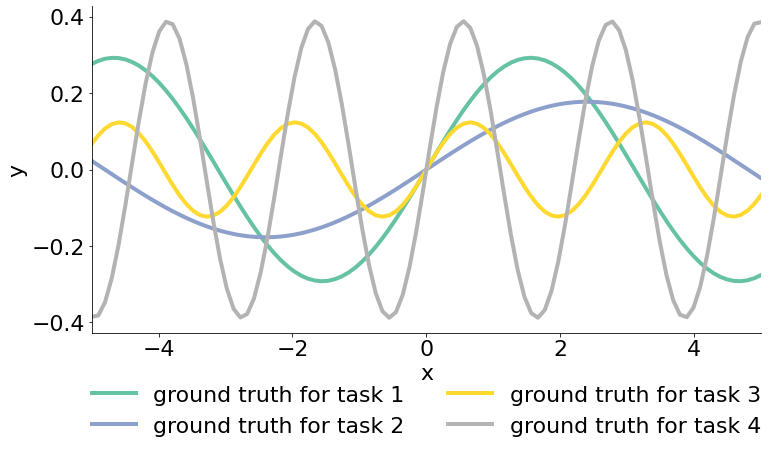

In [4]:
key = random.PRNGKey(0)
fig = plt.figure(figsize=(12, 6))

colors = cm.Set2(jnp.linspace(0, 1, n_tasks))

data_tasks = []
for task in range(n_tasks):

    key, subkey = random.split(key)
    data_train, data_test, phase, amplitude = generate_task(key)
    # save the samples for later
    data_tasks.append((data_train, data_test))

    # generate the ground truth regression curve for plotting
    xs = jnp.linspace(MIN_X, MAX_X, 100)
    ys = jnp.sin(phase * xs) * amplitude
    plt.plot(xs, ys, linewidth=4, label=f'ground truth for task {task+1}', color=colors[task])

plt.xlim((MIN_X, MAX_X))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False, ncol=2)
# Hide the right and top spines
ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We call each one of the curves above a "task". For each task, we have access to 12 samples drawn uniformly, that we split among a train and test set of the same size.

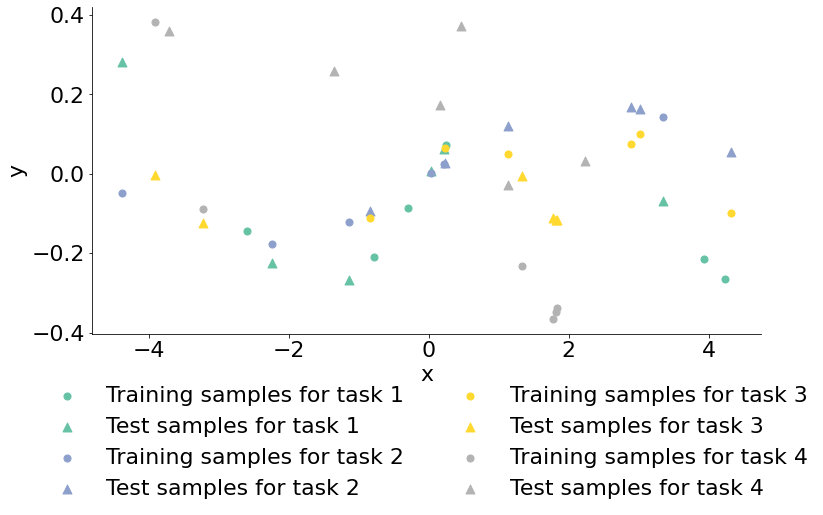

In [5]:
fig = plt.figure(figsize=(12, 6))
for task, ((x_train, y_train), (x_test, y_test)), in enumerate(data_tasks):
    plt.scatter(x_train, y_train, marker='o', s=50, label=f"Training samples for task {task+1}", color=colors[task])
    plt.scatter(x_test, y_test, marker='^', s=80, label=f"Test samples for task {task+1}", color=colors[task])
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False, ncol=2)
ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.show()

Let $\mathcal{L_i}$ (resp. $\hat{\mathcal{L_i}}$) denote the the train set (resp. test set) loss of the $i$-th task. Our goal is to learn a set of weights $\theta$ such that a model trained on a new task with the regularized loss $\mathcal{L_i}(\cdot) + \frac{}{}\|\cdot - \theta\|^2$ has a as small generalization error as possible.
[(Rajeswaran et al., 2019)](https://arxiv.org/pdf/1909.04630.pdf) frame this as the following bi-level problem


$$
\text{argmin}_{\theta} \sum_{i=1}^K \hat{\mathcal{L}_i}(x_i(\theta)) \text{ subject to } x_i(\theta) \in \text{argmin}_{x} {\mathcal{L}}_i(x) + \frac{\lambda}{2}\|x - \theta\|^2\,,
$$


In the following cells we'll define the inner objective ${\mathcal{L}}_i(x) + \frac{\lambda}{2}\|x - \theta\|^2$ as ```inner_loss``` and the outer objective $\hat{\mathcal{L_i}}$ as ```outer_loss```. Both losses are a quadratic loss using as predictive model a multi-layer perceptron.

In [6]:
class SimpleMLP(nn.Module):
  features: Sequence[int]
  dtype: Any

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
      x = nn.Dense(feat, name=f'layers_{i}', param_dtype=self.dtype)(x)
      if i != len(self.features) - 1:
        x = nn.swish(x)
    return x

In [7]:
key, subkey = random.split(random.PRNGKey(0), 2)
dummy_input = random.uniform(key, (1,), dtype=jnp.float64)

model = SimpleMLP(features=[20, 20, 20, 1], dtype=jnp.float64)

The regressor is a neural network model with 2 hidden layers of size 40 with ReLU nonlinearities.

In [8]:
def inner_loss(x, outer_parameters, data, regularization=L2REG):
  samples, targets = data
  prediction = model.apply(x, samples)
  mse = jnp.mean((prediction - targets)**2)
  x_m_outer_parameters = tree_util.tree_add_scalar_mul(x, -1, outer_parameters)
  reg = (regularization / 2) * tree_util.tree_l2_norm(x_m_outer_parameters, squared=True)
  return mse + reg


def outer_loss(outer_params, inner_parameters, data):
  # inner parameters is passed 
  # iterate on the first K-1 tasks
  loss = 0.
  task_params = []
  for (data_train, _), in_params in zip(data, inner_parameters):
    lbfgs = LBFGS(inner_loss, maxiter=2000, tol=1e-12)
    in_params_sol, _ = lbfgs.run(in_params, outer_params, data_train)
    prediction = model.apply(in_params_sol, x_test)
    loss += jnp.mean((prediction - y_test)**2)
    task_params.append(in_params_sol)
  return loss, task_params

In [9]:
key, subkey = random.split(random.PRNGKey(0), 2)

# initialize inner and outer params
inner_params = []
for _ in data_tasks:
  key, subkey = random.split(key)
  inner_params.append(model.init(key, dummy_input))

key, subkey = random.split(key)
outer_params = model.init(key, dummy_input)

gradient_subopt = []

solver = OptaxSolver(opt=optax.adam(1e-3), fun=outer_loss, maxiter=100, has_aux=True)
state = solver.init_state(outer_params, inner_params, data_tasks[:-1])
jitted_update = jax.jit(solver.update)

for it in range(solver.maxiter):
  outer_params, state = jitted_update(outer_params, state, state.aux, data_tasks[:-1])
  gradient_subopt.append(solver.l2_optimality_error(outer_params, state.aux, data_tasks[:-1]))

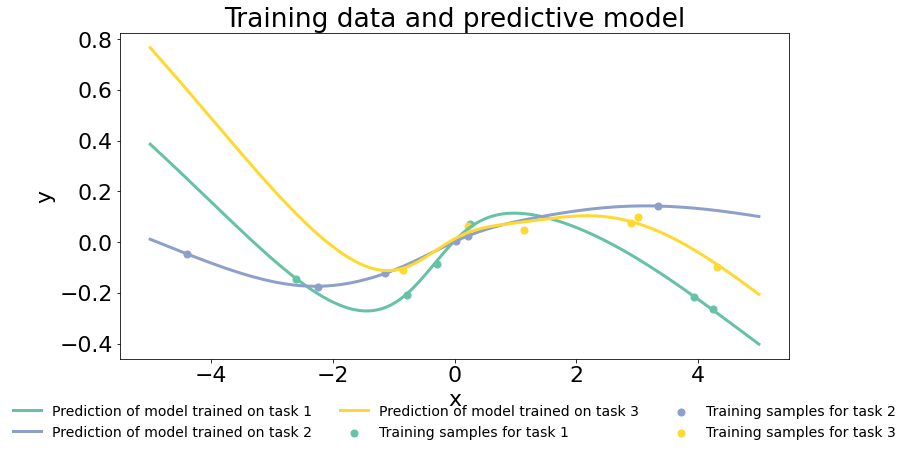

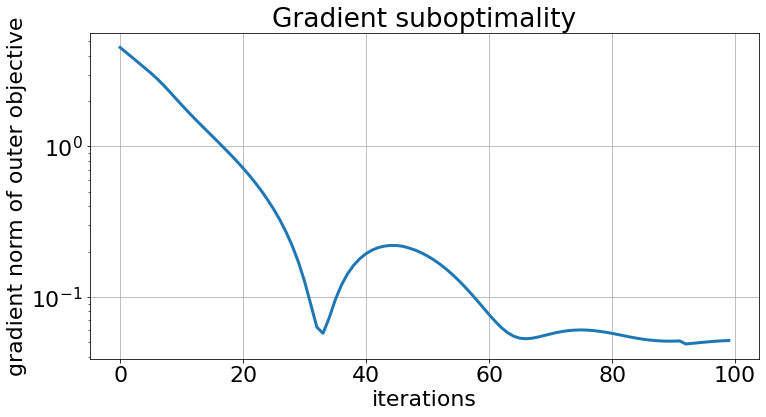

In [10]:
xx = jnp.linspace(MIN_X, MAX_X, 200)
plt.title(f'Training data and predictive model')
for task, ((x_train, y_train), test) in enumerate(data_tasks[:-1]):
  plt.scatter(x_train, y_train, marker='o', s=50, label=f"Training samples for task {task+1}", color=colors[task])
  prediction = jax.lax.stop_gradient(model.apply(state.aux[task], xx.reshape((-1, 1))))
  plt.plot(xx, prediction.ravel(), color=colors[task], lw=3, label=f"Prediction of model trained on task {task+1}")
plt.legend(loc='upper center', fontsize=14, bbox_to_anchor=(0.5, -0.1), frameon=False, ncol=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.title('Gradient suboptimality')
plt.plot(gradient_subopt, lw=3)
plt.yscale('log')
plt.ylabel("gradient norm of outer objective")
plt.xlabel("iterations")
plt.grid()
plt.show()

In [11]:
# now we consider the last task, which we haven't used for training
train, test = data_tasks[-1]

params, _ = LBFGS(
    fun=inner_loss, tol=1e-12, maxiter=2000).run(
    model.init(key, dummy_input), outer_params, train)

params_without_regularization, _ = LBFGS(
    fun=inner_loss, tol=1e-12, maxiter=2000).run(
    model.init(key, dummy_input), outer_params, train, regularization=0)

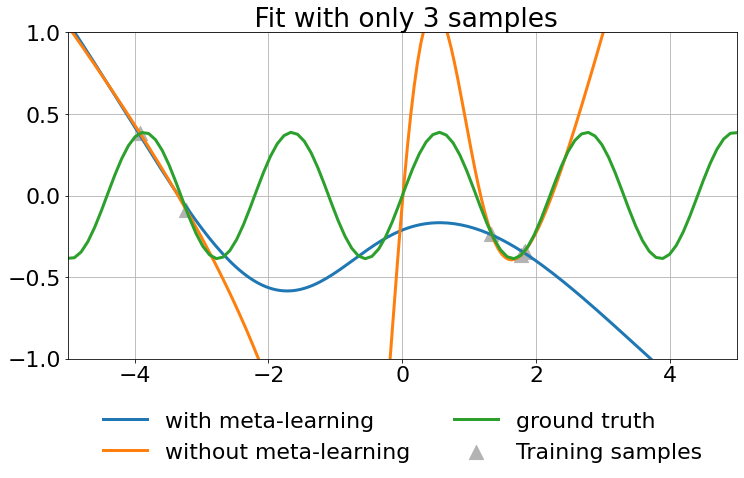

In [15]:
xx = jnp.linspace(MIN_X, MAX_X, 200)
prediction = model.apply(params, xx.reshape((-1, 1)))
prediction_without_regularization = model.apply(params_without_regularization, xx.reshape((-1, 1)))

plt.title(" Fit with only 3 samples")
plt.plot(xx, prediction.ravel(), lw=3, label="with meta-learning")
plt.plot(xx, prediction_without_regularization.ravel(), lw=3, label="without meta-learning")
plt.scatter(train[0], train[1], marker='^', s=200, label=f"Training samples", color=colors[-1])
plt.plot(xs, ys, lw=3, label="ground truth")
plt.ylim((-1, 1))
plt.xlim(MIN_X, MAX_X)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False, ncol=2)
plt.grid()
plt.show()